In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, torch, pickle, csv
import numpy as np
import scipy as sp
sys.path.append('/lfs/1/danfu/metal')
sys.path.append('/lfs/1/danfu/sequential_ws')
from metal.metrics import metric_score
from torch.nn.functional import normalize
from DP.label_model import *
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda:0')

# Load Data

In [4]:
L_train_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_train_100_windows_downsampled.npz'
L_dev_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_val_windows_downsampled_same_val_test.npz'
Y_dev_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/Y_val_windows_downsampled_same_val_test.npy'
L_test_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_test_windows_downsampled_same_val_test.npz'
Y_test_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/Y_test_windows_downsampled_same_val_test.npy'

stride = 1
L_train_raw = sp.sparse.load_npz(L_train_path).todense()[::stride]
L_dev_raw = sp.sparse.load_npz(L_dev_path).todense()
Y_dev_raw = np.load(Y_dev_path)
L_test_raw = sp.sparse.load_npz(L_test_path).todense()
Y_test_raw = np.load(Y_test_path)

T = 5

L_train = torch.FloatTensor(L_train_raw[:L_train_raw.shape[0] - (L_train_raw.shape[0] % T)]).to(device)
L_dev = torch.FloatTensor(L_dev_raw[:L_dev_raw.shape[0] - (L_dev_raw.shape[0] % T)]).to(device)
Y_dev = torch.FloatTensor(Y_dev_raw[:Y_dev_raw.shape[0] - (Y_dev_raw.shape[0] % T)]).to(device)
L_test = torch.FloatTensor(L_test_raw[:L_test_raw.shape[0] - (L_test_raw.shape[0] % T)]).to(device)
Y_test = torch.FloatTensor(Y_test_raw[:Y_test_raw.shape[0] - (Y_test_raw.shape[0] % T)]).to(device)
m_per_task = L_train.size(1)
n_frames_train = L_train.size(0)
n_patients_train = n_frames_train//T
n_frames_dev = L_dev.size(0)
n_patients_dev = n_frames_dev//T
n_frames_test = L_test.size(0)
n_patients_test = n_frames_test//T

# MRI_data_naive = {'Li_train': (L_train.unsqueeze(2) == torch.FloatTensor([-1,1,0]).to(device).unsqueeze(0).unsqueeze(0)).argmax(2),
#                   'Li_dev': (L_dev.unsqueeze(2) == torch.FloatTensor([-1,1,0]).to(device).unsqueeze(0).unsqueeze(0)).argmax(2),
#                   'R_dev': (Y_dev.unsqueeze(1) == torch.FloatTensor([-1,1]).to(device).unsqueeze(0)).argmax(1),
#                   'm':m_per_task, 'T':1,
#                  }

# don't need to transform the raw data
MRI_data_naive = {'Li_train': L_train.long().to(device),
                  'Li_dev': L_dev.long().to(device),
                  'R_dev': Y_dev.long().to(device),
                  'Li_test': L_test.long().to(device),
                  'R_test': Y_test.long().to(device),
                  'm':m_per_task, 'T':1,
                 }
MRI_data_naive['class_balance'] = normalize((MRI_data_naive['R_dev'].unsqueeze(1)==torch.arange(2, device=device).unsqueeze(0)).sum(0).float(), 
                                            dim=0, p=1)
MRI_data_temporal = {'Li_train': MRI_data_naive['Li_train'].view(n_patients_train, (m_per_task*T)),
                     'Li_dev': MRI_data_naive['Li_dev'].view(n_patients_dev, (m_per_task*T)),
                     'R_dev': MRI_data_naive['R_dev']*(2**T-1),
                     'Li_test': MRI_data_naive['Li_test'].view(n_patients_test, (m_per_task*T)),
                     'R_test': MRI_data_naive['R_test']*(2**T-1),
                     'm': m_per_task * T, 'T': T,
                    } 
MRI_data_temporal['class_balance'] = normalize((MRI_data_temporal['R_dev'].unsqueeze(1)==torch.arange(2**T, device=device).unsqueeze(0)).sum(0).float(), 
                                                dim=0, p=1)

In [41]:
from metal.label_model.baselines import MajorityLabelVoter

# majority vote of LFs
mv = MajorityLabelVoter()
print('Majority Label Voter Metrics:')
mv_score = mv.score((MRI_data_naive['Li_dev'],MRI_data_naive['R_dev']), metric=['accuracy','precision', 'recall', 'f1'])

mv_predictions = mv.predict(MRI_data_naive['Li_train']).astype(float)
mv_predictions[mv_predictions==2.] = 0.

Majority Label Voter Metrics:
Accuracy: 0.951
Precision: 0.828
Recall: 0.936
F1: 0.879
        y=1    y=2   
 l=1    322    67    
 l=2    22    1404   


# Naive Model

In [6]:
naive_model = DPLabelModel(m=m_per_task, 
                           T=1,
                           edges=[],
                           coverage_sets=[[0,]]*m_per_task,
                           mu_sharing=[[i,] for i in range(m_per_task)],
                           phi_sharing=[],
                           device=device,
                           # class_balance=MRI_data_naive['class_balance'], 
                           seed=0)
optimize(naive_model, L_hat=MRI_data_naive['Li_train'], num_iter=3000, lr=4.087885261759692e-05,
         momentum=0.9, clamp=True, seed=2)

iteration=0 loss=50.763729095458984
iteration=300 loss=8.765926361083984
iteration=600 loss=3.584846258163452
iteration=900 loss=1.8508527278900146
iteration=1200 loss=0.9663214683532715
iteration=1500 loss=0.6240480542182922
iteration=1800 loss=0.49020180106163025
iteration=2100 loss=0.41870707273483276
iteration=2400 loss=0.3748452961444855
iteration=2700 loss=0.344853013753891
iteration=2999 loss=0.3229215145111084


In [7]:
R_pred = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.142
F1: 0.413
Recall: 0.747
Precision: 0.286


In [38]:
MRI_data_naive['R_dev'].cpu()

tensor([1, 2, 2,  ..., 2, 2, 2])

In [39]:
R_pred_flipped.cpu()

tensor([1, 0, 0,  ..., 1, 1, 1])

In [8]:
# Flipping params
print("Flipping Parameters")
naive_model.flip_params()
R_pred_flipped = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred_flipped.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Flipping Parameters
Accuracy: 0.048
F1: 0.138
Recall: 0.253
Precision: 0.095


# Timeseries model

In [23]:
MRI_data_temporal['class_balance']

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       device='cuda:0')

In [22]:
MRI_data_temporal['class_balance'] = normalize((MRI_data_temporal['R_dev'].unsqueeze(1)==torch.arange(2**T, device=device).unsqueeze(0)).sum(0).float(), 
                                                dim=0, p=1)

In [27]:
valid_target = Y_dev.long()
T = 5

feasible_y = np.array([[-1, -1, -1, -1, -1],
        [-1,  1, -1, -1, -1],
        [ 1, -1, -1, -1, -1],
        [ 1,  1, -1, -1, -1],
        [-1, -1,  1, -1, -1],
        [-1,  1,  1, -1, -1],
        [ 1, -1,  1, -1, -1],
        [ 1,  1,  1, -1, -1],
        [-1, -1, -1,  1, -1],
        [-1,  1, -1,  1, -1],
        [ 1, -1, -1,  1, -1],
        [ 1,  1, -1,  1, -1],
        [-1, -1,  1,  1, -1],
        [-1,  1,  1,  1, -1],
        [ 1, -1,  1,  1, -1],
        [ 1,  1,  1,  1, -1],
        [-1, -1, -1, -1,  1],
        [-1,  1, -1, -1,  1],
        [ 1, -1, -1, -1,  1],
        [ 1,  1, -1, -1,  1],
        [-1, -1,  1, -1,  1],
        [-1,  1,  1, -1,  1],
        [ 1, -1,  1, -1,  1],
        [ 1,  1,  1, -1,  1],
        [-1, -1, -1,  1,  1],
        [-1,  1, -1,  1,  1],
        [ 1, -1, -1,  1,  1],
        [ 1,  1, -1,  1,  1],
        [-1, -1,  1,  1,  1],
        [-1,  1,  1,  1,  1],
        [ 1, -1,  1,  1,  1],
        [ 1,  1,  1,  1,  1]])

feasible_y[feasible_y==-1] = 0
feasible_y = feasible_y.tolist()
possibilities = list(map(lambda l : ''.join(map(str,l)), feasible_y))

class_balance = np.empty(2 ** T)
#compute class balance from dev set and use laplace smoothing

valid_target_copy = np.copy(valid_target)
valid_target_copy[valid_target_copy == 2] = 0

assert len(valid_target_copy) % T == 0
num_windows = len(valid_target_copy) / T

freq = {}
for i in range(0, len(valid_target_copy), T):
    s = ''.join(map(str,valid_target_copy[i:i+T]))
    if s in freq:
        freq[s] += 1
    else:
        freq[s] = 1

for i in range(len(class_balance)):
    if possibilities[i] in freq and freq[possibilities[i]] > 5:
        class_balance[i] = (freq[possibilities[i]] + 1) / (num_windows + len(possibilities))
    else:
        class_balance[i] = 0.

In [29]:
valid_target

tensor([1, 2, 2,  ..., 2, 2, 2], device='cuda:0')

In [35]:
class_balance[class_balance == 0.] = 0.01
class_balance = class_balance/np.sum(class_balance)

In [37]:
%%time
best = None
for iterations in [25]:
    for learning_rate in [1e-5, 1e-6, 1e-7]:
        print(iterations, learning_rate)
        max_seed = 5
        temporal_models = [None,]*max_seed
        for seed in range(max_seed):
            print(seed)
            markov_model = DPLabelModel(m=m_per_task*T, 
                                        T=T,
                                        edges=[(i,i+m_per_task) for i in range((T-1)*m_per_task)],
                                        coverage_sets=[[t,] for t in range(T) for _ in range(m_per_task)],
                                        mu_sharing=[[t*m_per_task+i for t in range(T)] for i in range(m_per_task)],
                                        phi_sharing=[[(t*m_per_task+i, (t+1)*m_per_task+i)
                                                      for t in range(T-1)] for i in range(m_per_task)],
                                        device=device,
                                        class_balance=torch.tensor(class_balance).float().to(device),
                                        seed=seed)
            optimize(markov_model, L_hat=MRI_data_temporal['Li_train'], num_iter=iterations,
                     lr=1e-5, momentum=0.8, clamp=True, 
                     verbose=False, seed=seed)
            temporal_models[seed] = markov_model

        for seed, model in enumerate(temporal_models):
            Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
            R_pred_frame_label = model.predict_element_proba(Li_dev.to(device)) #predict per element

            scores = [iterations, seed, model]
            for metric in ['accuracy', 'f1', 'recall', 'precision']:
                score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
                print(f"{metric.capitalize()}: {score:.3f}")

                scores.append(score)
                
            model.flip_params()
            R_pred_frame_label = model.predict_element_proba(Li_dev.to(device)) #predict per element

            for metric in ['accuracy', 'f1', 'recall', 'precision']:
                score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
                print(f"{metric.capitalize()}: {score:.3f}")

                scores.append(score)
            
            model.flip_params()

            if best == None or scores[4] > max(best[4], best[8]) or scores[8] > max(best[4], best[8]):
                best = scores
            print()

print(best)

25 1e-05
0
1
2
3
4
Accuracy: 0.183
F1: 0.469
Recall: 0.965
Precision: 0.309
Accuracy: 0.021
F1: 0.123
Recall: 0.110
Precision: 0.138

Accuracy: 0.152
F1: 0.270
Recall: 0.802
Precision: 0.162
Accuracy: 0.080
F1: 0.531
Recall: 0.422
Precision: 0.718

Accuracy: 0.174
F1: 0.381
Recall: 0.919
Precision: 0.240
Accuracy: 0.047
F1: 0.337
Recall: 0.247
Precision: 0.528

Accuracy: 0.176
F1: 0.486
Recall: 0.927
Precision: 0.330
Accuracy: 0.021
F1: 0.059
Recall: 0.110
Precision: 0.040

Accuracy: 0.161
F1: 0.364
Recall: 0.849
Precision: 0.232
Accuracy: 0.002
F1: 0.022
Recall: 0.012
Precision: 0.308

25 1e-06
0
1
2
3
4
Accuracy: 0.183
F1: 0.469
Recall: 0.965
Precision: 0.309
Accuracy: 0.021
F1: 0.123
Recall: 0.110
Precision: 0.138

Accuracy: 0.152
F1: 0.270
Recall: 0.802
Precision: 0.162
Accuracy: 0.080
F1: 0.531
Recall: 0.422
Precision: 0.718

Accuracy: 0.174
F1: 0.381
Recall: 0.919
Precision: 0.240
Accuracy: 0.047
F1: 0.337
Recall: 0.247
Precision: 0.528

Accuracy: 0.176
F1: 0.486
Recall: 0.927
Pr

In [9]:
best_model = best[2]

NameError: name 'best' is not defined

In [9]:
R_pred_frame_label = best_model.predict_element_proba(Li_dev.to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.143
F1: 0.806
Recall: 0.756
Precision: 0.864


In [12]:
Li_test = torch.LongTensor(MRI_data_temporal['Li_test'].cpu().numpy())
R_pred_frame_label = best_model.predict_element_proba(Li_test.to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_test.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.120
F1: 0.784
Recall: 0.738
Precision: 0.838


In [24]:
best_model.flip_params()

In [25]:
Li_dev = torch.LongTensor(MRI_data_temporal['Li_train'].cpu().numpy())
R_pred_frame_label = best_model.predict_element_proba(Li_dev.to(device)) #predict per element

# for metric in ['accuracy', 'f1', 'recall', 'precision']:
#     score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
#     print(f"{metric.capitalize()}: {score:.3f}")

(array([215065., 192578., 245527., 150370., 133418.,  55598.,  38484.,
         18650.,  10069.,   3431.]),
 array([6.19463015e-06, 9.98403258e-02, 1.99674457e-01, 2.99508588e-01,
        3.99342719e-01, 4.99176850e-01, 5.99010981e-01, 6.98845113e-01,
        7.98679244e-01, 8.98513375e-01, 9.98347506e-01]),
 <a list of 10 Patch objects>)

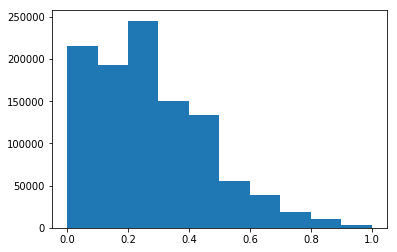

In [26]:
plt.hist(R_pred_frame_label)

In [13]:
torch.save(best_model, 'models/ts_labelmodel_best_tuning_downsampled_same_val_test.pth')

In [10]:
best_model = torch.load('models/ts_labelmodel_best_tuning_downsampled_same_val_test.pth')

# Save/Load best model

In [15]:
model = best_model

In [3]:
model = torch.load('models/ts_labelmodel.pth').to(device)

In [16]:
R_pred_frame_label = model.eval().predict_element_proba(
    MRI_data_temporal['Li_dev'].to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.143
F1: 0.806
Recall: 0.756
Precision: 0.864


In [17]:
R_pred_frame_label = model.eval().predict_element_proba(
    MRI_data_temporal['Li_test'].to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_test.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.120
F1: 0.784
Recall: 0.738
Precision: 0.838


# Make predictions for everything and save to disk

In [18]:
import numpy as np
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
import pickle
import rekall
from rekall.video_interval_collection import VideoIntervalCollection
from rekall.interval_list import IntervalList
from rekall.temporal_predicates import *
from metal.label_model.baselines import MajorityLabelVoter

## Load manually annotated data

In [19]:
with open('../../data/manually_annotated_shots.pkl', 'rb') as f:
    shots = VideoIntervalCollection(pickle.load(f))
with open('../../data/shot_detection_folds.pkl', 'rb') as f:
    shot_detection_folds = pickle.load(f)
clips = shots.dilate(1).coalesce().dilate(-1)
shot_boundaries = shots.map(
    lambda intrvl: (intrvl.start, intrvl.start, intrvl.payload)
).set_union(
    shots.map(lambda intrvl: (intrvl.end + 1, intrvl.end + 1, intrvl.payload))
).coalesce()
boundary_frames = {
    video_id: [
        intrvl.start
        for intrvl in shot_boundaries.get_intervallist(video_id).get_intervals()
    ]
    for video_id in shot_boundaries.get_allintervals()
}
video_ids = sorted(list(clips.get_allintervals().keys()))
frames_per_video = {
    video_id: sorted([
        f
        for interval in clips.get_intervallist(video_id).get_intervals()
        for f in range(interval.start, interval.end + 2)
    ])
    for video_id in video_ids
}
ground_truth = {
    video_id: [
        1 if f in boundary_frames[video_id] else 2
        for f in frames_per_video[video_id]
    ] 
    for video_id in video_ids
}

100%|██████████| 28/28 [00:00<00:00, 12861.74it/s]


## Load label matrix with all frames in it

In [20]:
with open('../../data/shot_detection_weak_labels/all_labels.pkl', 'rb') as f:
    weak_labels_all_movies = pickle.load(f)

## Load videos and number of frames per video

In [21]:
with open('../../data/frame_counts.pkl', 'rb') as f:
    frame_counts = pickle.load(f)
video_ids_all = sorted(list(frame_counts.keys()))
video_ids_train = sorted(list(set(video_ids_all).difference(set(video_ids))))

## Construct windows for each video

In [22]:
# First, construct windows of 16 frames for each video
windows = VideoIntervalCollection({
    video_id: [
        (f, f + 16, video_id)
        for f in range(0, frame_counts[video_id] - 16, 16)
    ]
    for video_id in video_ids_all
})

## Get ground truth labels for all windows

In [23]:
# Next, intersect the windows with ground truth and get ground truth labels for the windows
windows_intersecting_ground_truth = windows.filter_against(
    clips,
    predicate=overlaps()
).map(lambda intrvl: (intrvl.start, intrvl.end, 2))
windows_with_shot_boundaries = windows_intersecting_ground_truth.filter_against(
    shot_boundaries,
    predicate = lambda window, shot_boundary:
        shot_boundary.start >= window.start and shot_boundary.start < window.end
).map(
    lambda intrvl: (intrvl.start, intrvl.end, 1)
)
windows_with_labels = windows_with_shot_boundaries.set_union(
    windows_intersecting_ground_truth
).coalesce(
    predicate = equal(),
    payload_merge_op = lambda p1, p2: min(p1, p2)
)

## Get weak labels for all windows

In [24]:
# Label windows with the weak labels in our labeling functions
def label_window(per_frame_weak_labels):
    if 1 in per_frame_weak_labels:
        return 1
    if len([l for l in per_frame_weak_labels if l == 2]) >= len(per_frame_weak_labels) / 2:
        return 2
    return 0

windows_with_weak_labels = windows.map(
    lambda window: (
        window.start,
        window.end,
        [
            label_window([
                lf[window.payload][f-1]
                for f in range(window.start, window.end)
            ])
            for lf in weak_labels_all_movies
        ]
    )
)

# L matrix

In [ ]:
L_everything_windows = csr_matrix([
    intrvl.payload
    for video_id in sorted(list(video_ids_all))
    for intrvl in windows_with_weak_labels.get_intervallist(video_id).get_intervals()
]).todense()

In [41]:
with open('../../data/shot_detection_weak_labels/L_everything_windows_downsampled.npy', 'wb') as f:
    np.save(f, L_everything_windows)

In [25]:
with open('../../data/shot_detection_weak_labels/L_everything_windows_downsampled.npy', 'rb') as f:
    L_everything_windows = np.load(f)

# Convert L matrix to timeseries

In [26]:
T = 5
m_per_task = L_everything_windows.shape[1]

In [27]:
L_unlabelled = torch.FloatTensor(L_everything_windows[:L_everything_windows.shape[0] -
                                                      (L_everything_windows.shape[0] % T)]).to(device)

In [28]:
m_per_task_unlabelled = L_unlabelled.size(1)
n_frames_unlabelled = L_unlabelled.size(0)
n_patients_unlabelled = n_frames_unlabelled//T

In [29]:
L_unlabelled_ts = torch.LongTensor(
    L_unlabelled.view(n_patients_unlabelled, (m_per_task*T)).cpu().numpy())

# Predict everything

In [30]:
L_unlabelled_ts.shape[0]

1235081

In [68]:
model.flip_params()

In [31]:
predictions_val = model.eval().predict_element_proba(MRI_data_temporal['Li_dev'])

(array([1278.,  148.,   35.,   29.,   23.,   25.,   33.,   40.,   59.,
         145.]),
 array([1.88074608e-06, 9.98230374e-02, 1.99644194e-01, 2.99465351e-01,
        3.99286507e-01, 4.99107664e-01, 5.98928821e-01, 6.98749977e-01,
        7.98571134e-01, 8.98392291e-01, 9.98213447e-01]),
 <a list of 10 Patch objects>)

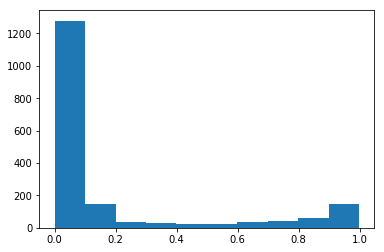

In [32]:
plt.hist(predictions_val)

In [33]:
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu().where(Y_dev.cpu() == torch.tensor(1.), torch.tensor(0.)),
                         np.round(predictions_val), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.931
F1: 0.806
Recall: 0.756
Precision: 0.864


In [34]:
predictions_everything = []
for i in range(0, L_unlabelled_ts.shape[0], 100000):
    print(i)
    start = i
    end = i + 100000
    labels = L_unlabelled_ts[start:end] if end < L_unlabelled_ts.shape[0] else L_unlabelled_ts[start:]
    predictions_for_labels = model.eval().predict_element_proba(labels.to(device))
    predictions_everything.append(predictions_for_labels)
    del predictions_for_labels
    torch.cuda.empty_cache()

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000


In [35]:
np.concatenate(predictions_everything).shape

(6175405,)

In [36]:
R_pred_probs_per_frame = np.concatenate(predictions_everything)

(array([3759959.,  734106.,  692494.,  145111.,  139209.,   97392.,
         131007.,  160536.,  158791.,  156800.]),
 array([1.41829968e-07, 9.99912640e-02, 1.99982386e-01, 2.99973508e-01,
        3.99964631e-01, 4.99955753e-01, 5.99946875e-01, 6.99937997e-01,
        7.99929120e-01, 8.99920242e-01, 9.99911364e-01]),
 <a list of 10 Patch objects>)

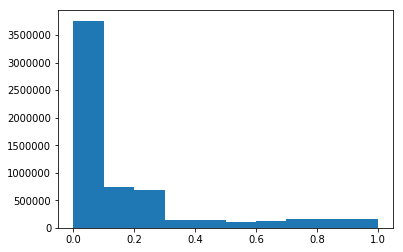

In [37]:
plt.hist(R_pred_probs_per_frame)

In [57]:
L_unlabelled_ts[-10:]

tensor([[2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0,
         0],
        [1, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 1, 0, 1, 0, 0, 2, 0, 1, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 1, 0, 2, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0,
         0]])

# Save predictions to disk

In [38]:
window_nums = [
    (video_id, intrvl.start, intrvl.end)
    for video_id in sorted(list(video_ids_all))
    for intrvl in windows_with_weak_labels.get_intervallist(video_id).get_intervals()
]

In [39]:
predictions_to_save_windows = [
    (window_info, np.array([prediction, 1. - prediction]))
    for window_info, prediction in zip(window_nums, R_pred_probs_per_frame)
]

In [40]:
# Because we needed to cut the predictions to a multiple of T
last_preds = []
for window_info in window_nums[len(predictions_to_save_windows):]:
    last_preds.append((window_info, np.array([0., 1.])))

In [41]:
last_preds

[]

In [ ]:
predictions_to_save_windows += last_preds

In [42]:
preds_np_windows = np.array(predictions_to_save_windows)

In [43]:
# save predictions to disk
with open('../../data/shot_detection_weak_labels/ts_weak_labels_all_windows_tuned_downsampled_same_val_test.npy', 'wb') as f:
    np.save(f, preds_np_windows)